In [1]:
import sys
sys.path.append('..') 
import numpy as np
import cv2 as cv
import os
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from keras import layers
from tensorflow import keras
import gc
import matplotlib.pyplot as plt
from tools.GA.FilterGeneticAlgorithm import GeneticAlgorithm
import random as rnd

In [2]:
path = "datasets/Covid19"

items = os.listdir(path)

folder_paths = [path+"/"+item for item in items if os.path.isdir(os.path.join(path, item))]

for path in folder_paths:
    print(path)

datasets/Covid19/Covid
datasets/Covid19/Normal
datasets/Covid19/Viral Pneumonia


In [3]:
def get_Data(folder_path,cls):
    X = []
    Y=[]
    for root, directories, files in os.walk(folder_path):
        for filename in files:
            img=cv.imread(os.path.join(root, filename))
            img=cv.cvtColor(img, cv.COLOR_RGB2BGR)
            img=cv.resize(img, (224,224))
            X.append(img)
            Y.append(cls)
    return X,Y

In [4]:
X=[]
Y=[]

for cls,folder_path in enumerate(folder_paths):
    x,y=get_Data(folder_path,cls)
    X=X+x
    Y=Y+y

In [5]:
X_train, X_test, Y_train, Y_test=train_test_split(X,Y,test_size=0.3)

In [6]:
X_train[2].shape

(224, 224, 3)

In [7]:
X_train=np.array(X_train)
Y_train=np.array(Y_train)
X_test=np.array(X_test)
Y_test=np.array(Y_test)

print(f"X_train:{X_train.shape} Y_train:{Y_train.shape} X_test:{X_test.shape} Y_test:{Y_test.shape}")

X_train:(190, 224, 224, 3) Y_train:(190,) X_test:(82, 224, 224, 3) Y_test:(82,)


In [8]:
model = keras.models.Sequential([
    layers.BatchNormalization(input_shape=(224, 224, 3)),
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(6, activation='softmax')
])

In [9]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)
splits = list(kf.split(X_test))

In [10]:
evaluations=0

for train_index, test_index in splits.copy():
    m= keras.models.clone_model(model)
    
    m.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

    train_index, test_index = train_index.tolist(), test_index.tolist()
    x_train, x_test, y_train, y_test = np.array(X_test)[train_index], np.array(X_test)[test_index], np.array(Y_test)[train_index], np.array(Y_test)[test_index]

    m.fit(x_train, y_train, epochs=1, batch_size=32)
    evaluations+=m.evaluate(x_test,y_test)[1]

    gc.collect()
print(evaluations/10)

1/1 [==============================] - 0s 125ms/step - loss: 6.2986 - accuracy: 0.3750
0.4347222238779068


In [11]:
ga=GeneticAlgorithm(X_train=X_train,X_test=X_test,Y_train=Y_train,Y_test=Y_test, model=model, loss=keras.losses.SparseCategoricalCrossentropy())

In [12]:
best_solution= ga.run(generation_limit=15, population_size=20)

--------------------------------------------------------------------------------
1/1 [==============================] - 0s 131ms/step - loss: 4.9665 - accuracy: 0.8421
filter [0, 179, 0, 255, 0, 255, 0, 0, 0, 0, 5, 1, 1, 100, 200, 0] fit: 0.5473684251308442
--------------------------------------------------------------------------------
1/1 [==============================] - 0s 130ms/step - loss: 1.1005 - accuracy: 0.5263
filter [33, 143, 12, 250, 19, 250, 137, 34, 92, 13, 3, 4, 2, 106, 129, 0] fit: 0.3789473742246628
--------------------------------------------------------------------------------
1/1 [==============================] - 0s 131ms/step - loss: 1.7860 - accuracy: 0.5263
filter [1, 111, 49, 140, 32, 154, 79, 106, 178, 184, 6, 2, 0, 64, 309, 2] fit: 0.46842105984687804
--------------------------------------------------------------------------------
1/1 [==============================] - 0s 131ms/step - loss: 1.1367 - accuracy: 0.5263
filter [49, 169, 13, 177, 0, 154, 69, 11,

In [13]:
print(f"\nbest filter :{best_solution.filter} fit: {best_solution.fit}")


best filter :[60, 141, 101, 202, 21, 255, 170, 31, 54, 129, 25, 0, 2, 106, 129, 1] fit: 0.8315789520740509


In [14]:
new_X_test=np.array(ga.get_newData(X_test,best_solution.filter))

new_X_test.shape

(82, 224, 224, 3)

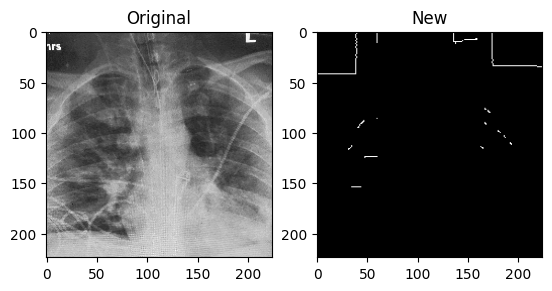

In [20]:
index=rnd.randint(0,len(X_test))

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(X_test[index])
ax1.set_title('Original')

ax2.imshow(new_X_test[index])
ax2.set_title('New')

plt.show()

In [21]:
evaluations=0

for train_index, test_index in splits.copy():
    m= keras.models.clone_model(model)

    m.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

    train_index, test_index = train_index.tolist(), test_index.tolist()
    x_train, x_test, y_train, y_test = np.array(new_X_test)[train_index], np.array(new_X_test)[test_index], np.array(Y_test)[train_index], np.array(Y_test)[test_index]

    m.fit(x_train, y_train, epochs=1, batch_size=32)
    evaluations+=m.evaluate(x_test,y_test)[1]
    del m
    gc.collect()
print(evaluations/10)

1/1 [==============================] - 0s 130ms/step - loss: 16.5575 - accuracy: 0.7500
0.7680555582046509
